In [2]:
import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy
import itertools
from scipy.special import psi, polygamma
import math

from scipy.linalg import sqrtm
from scipy.linalg import expm
from scipy.optimize import root_scalar

##Libraries in Toby's Code

import time
import operator
from functools import reduce

##Pickle libraries
import pickle
import gzip

In [31]:
def Xp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'X'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Yp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Y'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Zp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Z'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def ZZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'ZZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def YZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'YZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def hlist(N,J,h):
    h_list = [J]
    for i in range(1,N-1):
        h_list.append(h)
    h_list.append(-J)
    return h_list

def H_tfim(N,g,J,h_list):
    op = 0
    for i in range(1,N):
        op += g*Xp(i,N) + h_list[i-1]*Zp(i,N) + J*ZZp(i,N)
    op+=g*Xp(N,N) + h_list[N-1]*Zp(N,N)
    return op

def HaarState(N):
    coeffs = []
    for i in range(2**N):
        z = np.random.randn() # + 1j * np.random.randn()
        coeffs.append(z)
    coeffs = np.array(coeffs)
    hst = Statevector(coeffs)/np.linalg.norm(coeffs)
    return hst


def scrooge_ensemble(beta,N,H,M=100):
    rho = expm(-beta * SparsePauliOp.to_matrix(H))
    rho = rho / np.trace(rho)#Numpy array

    #convert to qiskit operators
    
    sqrt_rho = sqrtm(rho)
    rho_op = Operator(rho)

    #Form M random Haar states

    rand_states = []
    rand_states2 = []
    for i in range(M):
        rand_states.append(HaarState(N).data)
        rand_states2.append(HaarState(N))

    #Forming the Scrooge ensemble
    fin_states = [(np.dot(sqrt_rho,rand_state))/np.linalg.norm(np.dot(sqrt_rho,rand_state)) for rand_state in rand_states]
    #fin_states = [state.data[0] for state in fin_states]  # Convert to numpy arrays
    prob_list = [np.real(rand_state.expectation_value(rho_op)) for rand_state in rand_states2]

    prob_list_normalised = [p/np.sum(prob_list) for p in prob_list]
    return fin_states, prob_list_normalised

def genFockOp(op,position,size,levels=2,opdim=0):
    opList=[qt.qeye(levels) for x in range(size-opdim)]
    opList[position]=op
    return qt.tensor(opList)


def numberToBase(n, b,n_qubits):
    if n == 0:
        return np.zeros(n_qubits,dtype=int)
    digits = np.zeros(n_qubits,dtype=int)
    counter=0
    while n:
        digits[counter]=int(n % b)
        n //= b
        counter+=1
    return digits[::-1]

def get_all_paulis_N(n_qubits):
    ##get all pauli operators
    n_paulis=4**n_qubits

    pauli_list=np.zeros([n_paulis,n_qubits],dtype=int)
    for k in range(n_paulis):
        pauli_list[k,:]=numberToBase(k,4,n_qubits)

    levels=2
    opZ=[genFockOp(qt.sigmaz(),i,n_qubits,levels) for i in range(n_qubits)]
    opX=[genFockOp(qt.sigmax(),i,n_qubits,levels) for i in range(n_qubits)]
    opY=[genFockOp(qt.sigmay(),i,n_qubits,levels) for i in range(n_qubits)]

    
    opId=genFockOp(qt.qeye(levels),0,n_qubits)

    pauli_op_list=[]
    for k in range(n_paulis):
        pauli_string=pauli_list[k]
        pauli=opId
        for i in range(n_qubits):
            if(pauli_string[i]==1):
                pauli=opX[i]*pauli
            elif(pauli_string[i]==2):
                pauli=opY[i]*pauli
            elif(pauli_string[i]==3):
                pauli=opZ[i]*pauli
                
        pauli_op_list.append(pauli)
    return pauli_op_list,pauli_list





def get_conversion_matrix_mod_add_index(base_states):
    ##precompuation for computing renyi stabilizer entropy
    n_qubits=len(base_states[0])
    mag = len(base_states)
    to_index=2**np.arange(n_qubits)[::-1]
    conversion_matrix=np.zeros([mag,mag],dtype=int)
    for j_count in range(mag):
        base_j=base_states[j_count]
        k_plus_j=np.mod(base_states+base_j,2)
        k_plus_j_index=np.sum(k_plus_j*to_index,axis=1)
        conversion_matrix[j_count,:]=k_plus_j_index

    return conversion_matrix

def get_conversion_matrix_binary_prod(base_states):
    ##precompuation for computing renyi stabilizer entropy
    mag = len(base_states)
    conversion_matrix=np.zeros([mag,mag],dtype=int)
    
        
    for i_count in range(mag):
        base_i=base_states[i_count]
        binary_product=np.mod(np.dot(base_states,base_i),2)
        conversion_matrix[i_count,:]=(-1)**binary_product

    return conversion_matrix
def get_eigenvalues_and_eigenfunctions(h,g,N):
    eigvals = np.loadtxt(f"Test_data/mfim_eigvals_h={h},g={g},N={N}.txt")
    eigvecs = np.loadtxt(f"Test_data/mfim_eigvecs_h={h},g={g},N={N}.txt")
    return eigvals, eigvecs

def pauli_spectrum_fast2(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod):
    ##fast code to compute renyi entropy which uses numpy to full extent
    #requires precomputation with get_conversion_matrix_binary_prod and get_conversion_matrix_mod_add_index
    coeffs=state  #.data.toarray()[:,0]
    N = int(np.log2(len(coeffs)))
    
    prob_list_full=np.abs(np.dot(np.conjugate(coeffs)*conversion_matrix_binary_prod, coeffs[conversion_matrix_mod_add_index] ))**2
    
    #print(prob_list_full)
    epsilon_cutoff=10**-30
    prob_list=2**(-N)*prob_list_full[prob_list_full>epsilon_cutoff]

    return prob_list

def get_magic_exact(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=[2]):
    """
    Computes magic of state using fast pauli spectrum method
    """
    
    prob_list=pauli_spectrum_fast2(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod)
    renyi_fast_list=[]

    N = int(np.log2(len(state)))
    d = 2**N

    for alpha_p in alpha:
        if(alpha_p==1):
            renyi_fast= (-np.sum(prob_list*np.log2(prob_list)) - N)*(d/(d-1))  #-N*np.log(2)


    
        else:
        

            renyi_fast = 1/(1-alpha_p)*(np.log2(np.sum(prob_list**(alpha_p)) - 1/d**alpha_p) + alpha_p*np.log2(d) - np.log2(d-1) ) #-N*np.log(2)

        renyi_fast_list.append(renyi_fast)
    
    
    
    return renyi_fast_list,prob_list

def vn_reduced(phi,Na,N):

    ##Trace out the last N-Na qubits and take von Neumann entropy
    ##phi is a statevector
    ##Na is the number of qubits we want to keep

    ##N is the total number of qubits
    #If not statevectpor, convert to statevector
    if not isinstance(phi, Statevector):
        phi = Statevector(phi)

    keep = list(range(N - Na, N))         # e.g., if N=10, Na=4 → keep [6,7,8,9]
    trace_out = [i for i in range(N) if i not in keep]  # trace out last N - NA qubits

    #trace_out = list(range(Na, N))
    reduced = partial_trace(phi, trace_out)
    return entropy(reduced, base=np.e)

In [33]:
##Now, we have to first get the scrooge ensemble for a beta at a given N (from beta_list) and then compute the magic/EE for each state in the ensemble and weight it with the probability of that state in the ensemble

N_list = [12]
h = 0.35
J = 1
g = 1.1
M = 10
for N in N_list:
    print(f"N={N}")
    h_list = hlist(N,J,h)
    H = H_tfim(N,g,J,h_list)

    with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N}.pkl.gz", "rb") as f:
        beta_list = pickle.load(f)
    if N >=5:
        beta_vals = np.linspace(beta_list[1], beta_list[-2], 50)
    else:
        beta_vals = np.linspace(beta_list[1], beta_list[-2], 10)
    base_states=np.array([numberToBase(i, 2,N) for i in range(2**N)],dtype=int)

    ##these steps need only be run once
    #print("Get magic bases")
    conversion_matrix_binary_prod=get_conversion_matrix_binary_prod(base_states)
    #print("Get mod add base")
    conversion_matrix_mod_add_index=get_conversion_matrix_mod_add_index(base_states)

    magic_list_fin = []
    entropy_list = []
    
    
    for beta in beta_vals:
       
    
    #Get the scrooge ensemble
        fin_states, prob_list_normalised = scrooge_ensemble(beta,N,H,M=M)
        magic_list_total = np.zeros(4, dtype=float)
        entropy_val = 0
       
        #Compute magic for each state in the ensemble
        for ind in range(M):
            #print(fin_states[ind])
            magic_list, prob_list = get_magic_exact(fin_states[ind],conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=[0.5,1,2,3])
            #multiply by the probability of that state in the ensemble
            magic_list_np = np.array(magic_list)
            magic_list_np *= prob_list_normalised[ind]
            
           
            magic_list_total += magic_list_np
            entropy_val += prob_list_normalised[ind] * vn_reduced(fin_states[ind], N//2, N)
        magic_list_fin.append(magic_list_total)
        entropy_list.append(entropy_val)

        #Save the results
    with gzip.open(f"Full_data/scrooge_magic_tri_h={h},g={g},N={N}.pkl.gz", "wb") as f:
        pickle.dump((magic_list_fin), f)
    with gzip.open(f"Full_data/scrooge_entropy_tri_h={h},g={g},N={N}.pkl.gz", "wb") as f:
        pickle.dump((entropy_list), f)


        
        

N=12


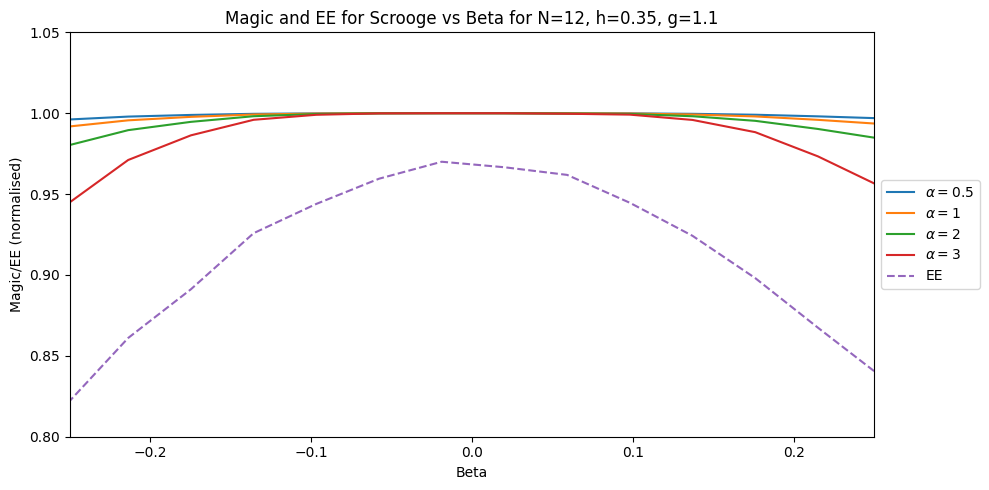

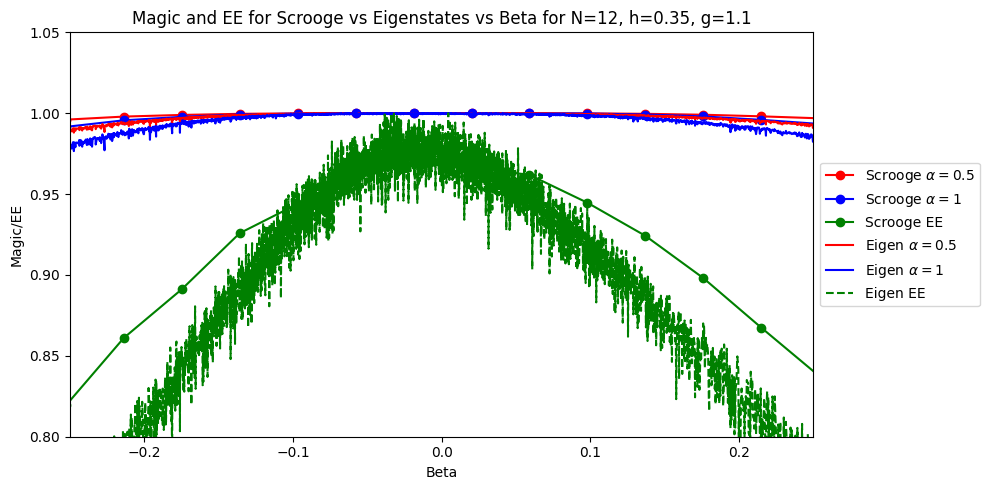

In [22]:
##Plot out the results first

N = 12
with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    beta_list = pickle.load(f)
with gzip.open(f"Full_data/scrooge_magic_tri_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    magic_list_fin = pickle.load(f)
with gzip.open(f"Full_data/scrooge_entropy_tri_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    ee_list = pickle.load(f)
#Separate the magic values into respective alphas
magic_alpha_05 = [magic[0] for magic in magic_list_fin]

magic_alpha_1 = [magic[1] for magic in magic_list_fin]
magic_alpha_2 = [magic[2] for magic in magic_list_fin]
magic_alpha_3 = [magic[3] for magic in magic_list_fin]

##normalise all the lists
magic_alpha_05 = np.array(magic_alpha_05)
magic_alpha_1 = np.array(magic_alpha_1)
magic_alpha_2 = np.array(magic_alpha_2)
magic_alpha_3 = np.array(magic_alpha_3)
ee_list = np.array(ee_list)
magic_alpha_05 /= np.max(magic_alpha_05)
magic_alpha_1 /= np.max(magic_alpha_1)
magic_alpha_2 /= np.max(magic_alpha_2)
magic_alpha_3 /= np.max(magic_alpha_3)
ee_list /= np.max(ee_list)

beta_list_disc = np.linspace(beta_list[1], beta_list[-2], len(magic_alpha_05))

offset =0.03
ee_list -= offset




##Now, we can use this polynomial to theplot the magic and EE v/s beta for the eigenstates of the Hamiltonian
plt.figure(figsize=(10, 5))
plt.plot(beta_list_disc, magic_alpha_05, label=r'$\alpha=0.5$')
plt.plot(beta_list_disc, magic_alpha_1, label=r'$\alpha=1$')
plt.plot(beta_list_disc, magic_alpha_2, label=r'$\alpha=2$')
plt.plot(beta_list_disc, magic_alpha_3, label=r'$\alpha=3$')
plt.plot(beta_list_disc, ee_list, label='EE', linestyle='--')
plt.title(f'Magic and EE for Scrooge vs Beta for N={N}, h={h}, g={g}')
plt.xlabel('Beta')
plt.ylabel('Magic/EE (normalised)')
plt.ylim(0.8,1.05)
plt.xlim(-0.25,0.25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
##NOw, we plot the magic and EE and the Scrooge magic and EE v/s beta for the eigenstates of the Hamiltonian

with gzip.open(f"Full_data/magic_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    magic_list_fin = pickle.load(f)
with gzip.open(f"Full_data/ee_h={h},g={g},N={N}.pkl.gz", "rb") as f:
    ee_list_eig = pickle.load(f)

#Separate the magic values into respective alphas
magic_alpha_05_eig = [magic[0] for magic in magic_list_fin]
magic_alpha_1_eig = [magic[1] for magic in magic_list_fin]
magic_alpha_2_eig = [magic[2] for magic in magic_list_fin]
magic_alpha_3_eig = [magic[3] for magic in magic_list_fin]

##normalise all the lists
magic_alpha_05_eig = np.array(magic_alpha_05_eig)
magic_alpha_1_eig = np.array(magic_alpha_1_eig)
magic_alpha_2_eig = np.array(magic_alpha_2_eig) 
magic_alpha_3_eig = np.array(magic_alpha_3_eig)
ee_list_eig = np.array(ee_list_eig)
magic_alpha_05_eig /= np.max(magic_alpha_05_eig)
magic_alpha_1_eig /= np.max(magic_alpha_1_eig)
magic_alpha_2_eig /= np.max(magic_alpha_2_eig)  
magic_alpha_3_eig /= np.max(magic_alpha_3_eig)
ee_list_eig /= np.max(ee_list_eig)

##NOw, we plot the scrooge values with marker 'o' and the eigenvalues with no special marker, ensuring that for the same \alpha, the same colour is used for both Scrooge and eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(beta_list_disc, magic_alpha_05, 'ro-', label=r'Scrooge $\alpha=0.5$')
plt.plot(beta_list_disc, magic_alpha_1, 'bo-', label=r'Scrooge $\alpha=1$')
#plt.plot(beta_list_disc, magic_alpha_2, 'o-', label=r'Scrooge $\alpha=2$')
#plt.plot(beta_list_disc, magic_alpha_3, 'o-', label=r'Scrooge $\alpha=3$')
plt.plot(beta_list_disc, ee_list, 'go-', label='Scrooge EE')
plt.plot(beta_list[1:-1], magic_alpha_05_eig[1:-1], 'r-', label=r'Eigen $\alpha=0.5$')
plt.plot(beta_list[1:-1], magic_alpha_1_eig[1:-1], 'b-', label=r'Eigen $\alpha=1$')
#plt.plot(beta_list[1:-1], magic_alpha_2_eig[1:-1], '-', label=r'Eigen $\alpha=2$')
#plt.plot(beta_list[1:-1], magic_alpha_3_eig[1:-1], '-', label=r'Eigen $\alpha=3$')
plt.plot(beta_list[1:-1], ee_list_eig[1:-1], 'g--', label='Eigen EE')
plt.title(f'Magic and EE for Scrooge vs Eigenstates vs Beta for N={N}, h={h}, g={g}')
plt.xlabel('Beta')
plt.xlim(-0.25,0.25)
plt.ylim(0.8,1.05)
plt.ylabel('Magic/EE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


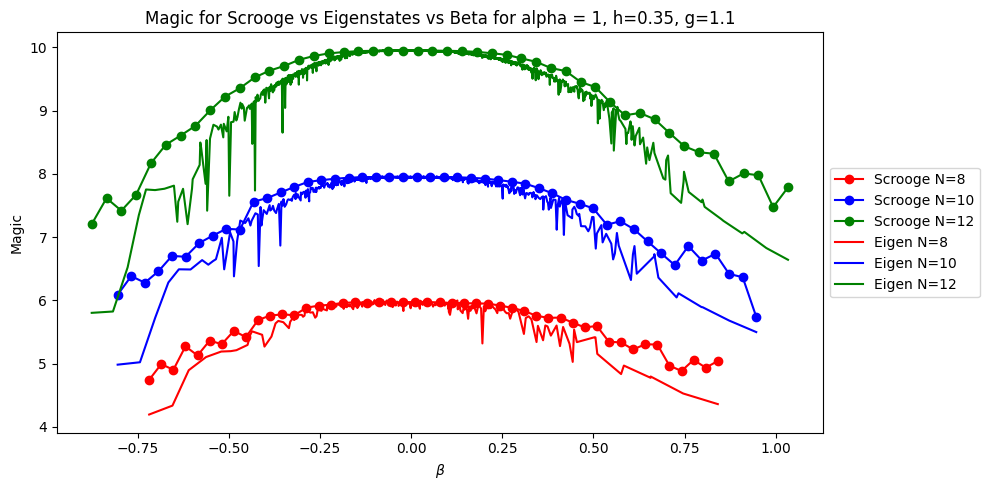

In [10]:
##Load files for N = 8,10,12 and plot them on the same axis, only plotting \alpha = 1 for magic

N1 = 8
N2 = 10
N3 = 12 

h=0.35
g=1.1

with gzip.open(f"Full_data/scrooge_magic_tri_h={h},g={g},N={N1}.pkl.gz", "rb") as f:
    magic_list_fin_N1 = pickle.load(f)
with gzip.open(f"Full_data/scrooge_magic_tri_h={h},g={g},N={N2}.pkl.gz", "rb") as f:
    magic_list_fin_N2 = pickle.load(f)
with gzip.open(f"Full_data/scrooge_magic_tri_h={h},g={g},N={N3}.pkl.gz", "rb") as f:
    magic_list_fin_N3 = pickle.load(f)  

with gzip.open(f"Full_data/scrooge_entropy_tri_h={h},g={g},N={N1}.pkl.gz", "rb") as f:
    ee_list_N1 = pickle.load(f)
with gzip.open(f"Full_data/scrooge_entropy_tri_h={h},g={g},N={N2}.pkl.gz", "rb") as f:
    ee_list_N2 = pickle.load(f)
with gzip.open(f"Full_data/scrooge_entropy_tri_h={h},g={g},N={N3}.pkl.gz", "rb") as f:
    ee_list_N3 = pickle.load(f)


#Load the eigenvalue magic and EE for N1, N2, N3
with gzip.open(f"Full_data/magic_h={h},g={g},N={N1}.pkl.gz", "rb") as f:
    magic_list_fin_eig_N1 = pickle.load(f)
with gzip.open(f"Full_data/magic_h={h},g={g},N={N2}.pkl.gz", "rb") as f:
    magic_list_fin_eig_N2 = pickle.load(f)
with gzip.open(f"Full_data/magic_h={h},g={g},N={N3}.pkl.gz", "rb") as f:
    magic_list_fin_eig_N3 = pickle.load(f)  

with gzip.open(f"Full_data/ee_h={h},g={g},N={N1}.pkl.gz", "rb") as f:
    ee_list_eig_N1 = pickle.load(f)
with gzip.open(f"Full_data/ee_h={h},g={g},N={N2}.pkl.gz", "rb") as f:
    ee_list_eig_N2 = pickle.load(f)
with gzip.open(f"Full_data/ee_h={h},g={g},N={N3}.pkl.gz", "rb") as f:
    ee_list_eig_N3 = pickle.load(f)

#Load the beta list for N1, N2, N3
with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N1}.pkl.gz", "rb") as f:
    beta_list_N1 = pickle.load(f)
with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N2}.pkl.gz", "rb") as f:
    beta_list_N2 = pickle.load(f)
with gzip.open(f"Full_data/beta_list_poly_h={h},g={g},N={N3}.pkl.gz", "rb") as f:
    beta_list_N3 = pickle.load(f)

#Separate the magic values into respective alphas
magic_alpha_1_N1 = [magic[1] for magic in magic_list_fin_N1]
magic_alpha_1_N2 = [magic[1] for magic in magic_list_fin_N2]
magic_alpha_1_N3 = [magic[1] for magic in magic_list_fin_N3]

magic_list_fin_eig_N1 = [magic[1] for magic in magic_list_fin_eig_N1]
magic_list_fin_eig_N2 = [magic[1] for magic in magic_list_fin_eig_N2]
magic_list_fin_eig_N3 = [magic[1] for magic in magic_list_fin_eig_N3]

"""##normalise all the lists
magic_alpha_1_N1 = np.array(magic_alpha_1_N1)
magic_alpha_1_N2 = np.array(magic_alpha_1_N2)
magic_alpha_1_N3 = np.array(magic_alpha_1_N3)
ee_list_N1 = np.array(ee_list_N1)
ee_list_N2 = np.array(ee_list_N2)
ee_list_N3 = np.array(ee_list_N3)
magic_alpha_1_N1 /= np.max(magic_alpha_1_N1)
magic_alpha_1_N2 /= np.max(magic_alpha_1_N2)
magic_alpha_1_N3 /= np.max(magic_alpha_1_N3)
ee_list_N1 /= np.max(ee_list_N1)
ee_list_N2 /= np.max(ee_list_N2)
ee_list_N3 /= np.max(ee_list_N3)"""

beta_list_disc_N1 = np.linspace(beta_list_N1[1], beta_list_N1[-2], len(magic_alpha_1_N1[1:-1]))
beta_list_disc_N2 = np.linspace(beta_list_N2[1], beta_list_N2[-2], len(magic_alpha_1_N2[1:-1]))
beta_list_disc_N3 = np.linspace(beta_list_N3[1], beta_list_N3[-2], len(magic_alpha_1_N3[1:-1]))   

plt.figure(figsize=(10, 5))
plt.plot(beta_list_disc_N1, magic_alpha_1_N1[1:-1], 'ro-', label=f'Scrooge N={N1}')
plt.plot(beta_list_disc_N2, magic_alpha_1_N2[1:-1], 'bo-', label=f'Scrooge N={N2}')
plt.plot(beta_list_disc_N3, magic_alpha_1_N3[1:-1], 'go-', label=f'Scrooge N={N3}')
plt.plot(beta_list_N1[1:-1], magic_list_fin_eig_N1[1:-1], 'r-', label=f'Eigen N={N1}')
plt.plot(beta_list_N2[1:-1], magic_list_fin_eig_N2[1:-1], 'b-', label=f'Eigen N={N2}')
plt.plot(beta_list_N3[1:-1], magic_list_fin_eig_N3[1:-1], 'g-', label=f'Eigen N={N3}')
"""plt.plot(beta_list_N1[1:-1], ee_list_eig_N1[1:-1], 'r--', label=f'Eigen EE N={N1}')
plt.plot(beta_list_N2[1:-1], ee_list_eig_N2[1:-1], 'b--', label=f'Eigen EE N={N2}')
plt.plot(beta_list_N3[1:-1], ee_list_eig_N3[1:-1], 'g--', label=f'Eigen EE N={N3}')"""
plt.title(f'Magic for Scrooge vs Eigenstates vs Beta for alpha = 1, h={h}, g={g}')
plt.xlabel(r'$\beta$')
plt.ylabel('Magic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

        